In [ ]:
!pip install transformers torch

In [ ]:
from transformers import CLIPProcessor, CLIPModel
import torch

In [ ]:
import math
import numpy as np
import pandas as pd

from PIL import Image
import shutil
import os
import glob
import matplotlib.pyplot as plt
plt.rcParams.update({'pdf.fonttype': 'truetype'})
from mpl_toolkits.axes_grid1 import ImageGrid

In [ ]:
model_id = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)

# move model to device if possible
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!git clone https://github.com/ikatsov/tensor-house-data.git  /content/images


Mounted at /content/drive
Cloning into '/content/images'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 128 (delta 7), reused 64 (delta 6), pack-reused 62
Receiving objects: 100% (128/128), 47.56 MiB | 28.77 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [ ]:
zip_path = '/content/drive/MyDrive/fashion_images.zip'
!unzip -q '/content/drive/MyDrive/fashion_images.zip' -d '/content/extracted_images_folder/'

Images found: 44096


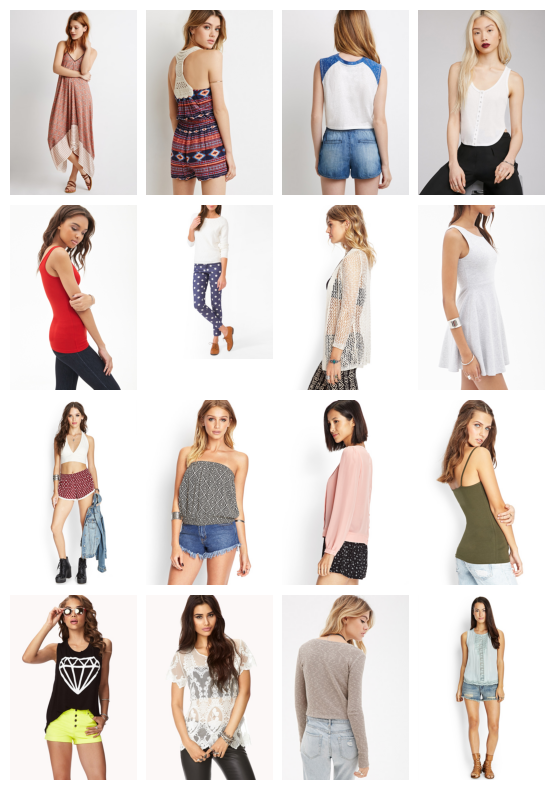

In [ ]:
from pathlib import Path

# Set the path to the images
image_paths = glob.glob('/content/extracted_images_folder/images/*.jpg')

# List all JPGs in the folder
images_files = image_paths

# Print some statistics
print(f'Images found: {len(images_files)}')

# Display images
rows, columns = (4, 4)
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(rows, columns),
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, images_files[:rows*columns]):
    ax.imshow(Image.open(im))
    ax.axis('off')
plt.show()

In [ ]:
#
# Path where the feature vectors will be stored
#
features_path = Path(".") / "features"
if os.path.exists(features_path):
    shutil.rmtree(features_path)
os.makedirs(features_path)

# Function that computes the feature vectors for a batch of images
def compute_clip_features(images_batch):
    # Load all the images from the files
    images = [Image.open(image_file) for image_file in images_batch]
    #print(images)
    # Preprocess all images
    #images_preprocessed = torch.stack([processor(image) for image in images]).to(device)

    with torch.no_grad():
      images = processor(text=None,images=images,return_tensors='pt')['pixel_values'].to(device)
      #print(images)
      image_features = model.get_image_features(images)
      image_features /= image_features.norm(dim=-1, keepdim=True)

    # Transfer the feature vectors back to the CPU and convert to numpy
    return image_features.cpu().numpy()

# Define the batch size
batch_size = 16


# Compute how many batches are needed
batches = math.ceil(len(images_files) / batch_size)

#
# Process each batch
#
for i in range(batches):
    print(f"Processing batch {i+1}/{batches}")

    batch_ids_path = features_path / f"{i:010d}.csv"
    batch_features_path = features_path / f"{i:010d}.npy"

    # Only do the processing if the batch wasn't processed yet
    if not batch_features_path.exists():
        try:
            # Select the images for the current batch
            batch_files = images_files[i*batch_size : (i+1)*batch_size]

            # Compute the features and save to a numpy file
            batch_features = compute_clip_features(batch_files)
            np.save(batch_features_path, batch_features)

            # Save the image IDs to a CSV file
            image_ids = [image_file.split(".")[0] for image_file in batch_files]
            image_ids_data = pd.DataFrame(image_ids, columns=['image_id'])
            image_ids_data.to_csv(batch_ids_path, index=False)
        except Exception as e:
            # Catch problems with the processing to make the process more robust
            print(f'Problem with batch {i} {e}')

Streaming output truncated to the last 5000 lines.
Processing batch 257/2756
[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=750x1101 at 0x7A99F2D4AE90>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=750x1101 at 0x7A99F2D4ADA0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=750x1101 at 0x7A99F297EA40>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=750x1101 at 0x7A99F297D300>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=750x1101 at 0x7A99F297E0E0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=750x1101 at 0x7A99F297F7C0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=750x1101 at 0x7A99F297E3E0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=750x1101 at 0x7A99F297DBA0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=750x1101 at 0x7A9B1E057B50>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=750x1101 at 0x7A99F297E080>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=750x1101 at 0x7A99F2B04B20>

In [ ]:
# Load all numpy files
features_list = [np.load(features_file) for features_file in sorted(features_path.glob("*.npy"))]

# Concatenate the features and store in a merged file
features = np.concatenate(features_list)
np.save(features_path / "features.npy", features)

# Load all the image IDs
image_ids = pd.concat([pd.read_csv(ids_file) for ids_file in sorted(features_path.glob("*.csv"))])
image_ids.to_csv(features_path / "image_ids.csv", index=False)


In [ ]:
# Load the image IDs
image_ids = pd.read_csv(features_path / 'image_ids.csv')
image_ids = list(image_ids['image_id'])

# Load the features vectors
image_features = np.load(features_path / 'features.npy')

# Convert features to Tensors: Float32 on CPU and Float16 on GPU
if device == "cpu":
    image_features = torch.from_numpy(image_features).float().to(device)
else:
    image_features = torch.from_numpy(image_features).to(device)

# Print some statistics
print(f"Images loaded: {len(image_ids)}")


Images loaded: 44096


0 ['/content/extracted_images_folder/images/WOMEN-Leggings-id_00006878-01_3_back', '/content/extracted_images_folder/images/WOMEN-Denim-id_00005892-05_2_side', '/content/extracted_images_folder/images/WOMEN-Rompers_Jumpsuits-id_00000033-05_3_back']
1 ['/content/extracted_images_folder/images/MEN-Shirts_Polos-id_00000846-03_2_side', '/content/extracted_images_folder/images/MEN-Sweaters-id_00002809-01_1_front', '/content/extracted_images_folder/images/MEN-Shirts_Polos-id_00000846-10_2_side']
2 ['/content/extracted_images_folder/images/WOMEN-Sweaters-id_00003233-03_2_side', '/content/extracted_images_folder/images/WOMEN-Skirts-id_00007549-02_2_side', '/content/extracted_images_folder/images/WOMEN-Sweaters-id_00006683-04_2_side']
3 ['/content/extracted_images_folder/images/WOMEN-Tees_Tanks-id_00007962-09_2_side', '/content/extracted_images_folder/images/WOMEN-Leggings-id_00001907-02_1_front', '/content/extracted_images_folder/images/WOMEN-Leggings-id_00002130-02_1_front']


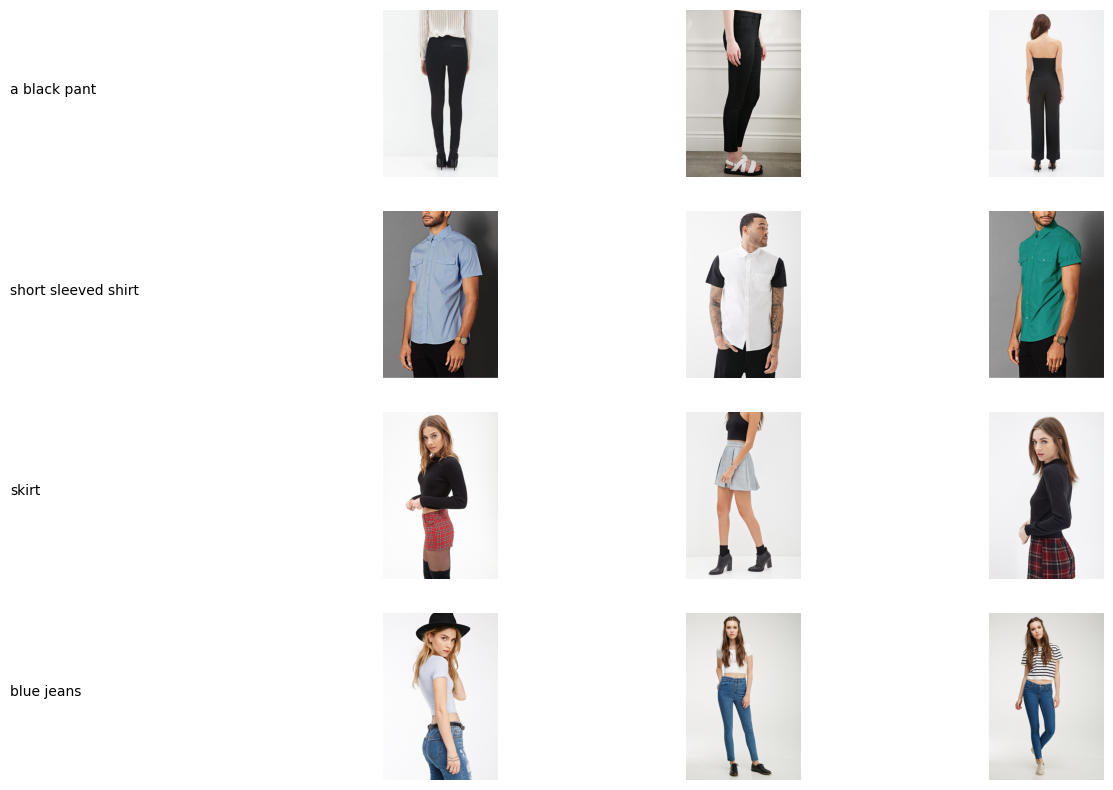

In [ ]:
def encode_search_query(search_query):
    with torch.no_grad():
        # Encode and normalize the search query using CLIP
        tokens = processor(
                           text = search_query,
                           padding=True,
                          images=None,
                           return_tensors='pt').to(device)

        text_encoded =  model.get_text_features(**tokens).to(device)
        text_encoded /= text_encoded.norm(dim=-1, keepdim=True)

    # Retrieve the feature vector
    return text_encoded

def find_best_matches(text_features, image_features, image_ids, results_count=3):
  # Compute the similarity between the search query and each image using the Cosine similarity
  similarities = (image_features @ text_features.T).squeeze(1)

  # Sort the images by their similarity score
  best_image_idx = (-similarities).argsort()

  # Return the image IDs of the best matches
  return [image_ids[i] for i in best_image_idx[:results_count]]

def search(search_query, image_features, image_ids, results_count=1):
  # Encode the search query
  text_features = encode_search_query(search_query)

  # Find the best matches
  return find_best_matches(text_features, image_features, image_ids, results_count)

#
# Search for images and visualize the results
#
search_queries = ['a black pant',
                  'short sleeved shirt',
                  'skirt',
                  'blue jeans']
n_results_per_query = 3

fig, ax = plt.subplots(len(search_queries), n_results_per_query + 1, figsize=(15, 10))
for i, search_query in enumerate(search_queries):
    result_image_ids = search(search_query, image_features, image_ids, n_results_per_query)
    print(i, result_image_ids)
    ax[i, 0].text(0.0, 0.5, search_query)
    ax[i, 0].axis('off')
    for j, image_id in enumerate(result_image_ids):
        image = Image.open(f'{image_id}.jpg')
        ax[i, j+1].imshow(image)
        ax[i, j+1].axis('off')

In [ ]:
import pinecone

# Load CSV file with IDs
df_ids = pd.read_csv('/content/features/image_ids.csv')
df_ids['image_id'] = df_ids['image_id'].apply(lambda x: x.replace('/content/extracted_images_folder/images/', ''))
# Load Numpy file with vectors
features = np.load('/content/features/features.npy')

pinecone.create_index("vectors", dimension=512, metric="cosine")
pinecone.describe_index("vectors")

api_key = 'bb5c549b-3015-44a6-9e7b-f7939252ffbc'
pinecone.init(api_key = 'bb5c549b-3015-44a6-9e7b-f7939252ffbc', environment="gcp-starter")

index = pinecone.Index("vectors")


for i in range(features.shape[0]):
                index.upsert(
                    vectors = [
                        {
                            'id': df_ids['image_id'][i],
                            'values': features[i].tolist()
                        }
                    ]
                )


